In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm

from statsmodels.formula.api import ols

from sklearn.preprocessing import LabelBinarizer
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.linear_model import LinearRegression as lr
from sklearn.linear_model import LogisticRegression as logreg


from sklearn.model_selection import train_test_split, cross_val_score, KFold, LeaveOneOut
from sklearn.metrics import accuracy_score

from sklearn.datasets import load_iris
from ucimlrepo import fetch_ucirepo

from matplotlib import pyplot as plt

# Lecture 4

## Cross-validation

When dealing with supervised learning algorithms, we need to assess the quality of the model we create out of the training data. This is called *cross-validation*. In today's lecture, we are going to cover the main types of cross-validation techniques:

Cross-validation techniques are vital for evaluating the performance of machine learning models, especially in supervised learning scenarios where labeled data is available. Here's a detailed explanation of the various cross-validation techniques we are going to use:

### 1. Hold-Out Cross-Validation:

#### Description

This is one of the simplest cross-validation techniques. It involves splitting the dataset into two parts: a training set and a validation set. The model is trained on the training set and evaluated on the validation set. Typically, a random portion of the data is selected for training and the remaining portion is used for validation.

#### Procedure

1. Randomly divide the dataset into a training set and a validation set.
2. Train the model on the training set.
3. Evaluate the model's performance on the test set.

#### Advantages

- Easy to implement.
- Suitable for large datasets where computational resources are limited.

#### Disadvantages

- The performance estimate can be highly dependent on the random split.
- May not be representative if the dataset is imbalanced.
- There is no information about the error bounds on the evaluation metric.

#### An example

We have done examples of this kind before. Let us repeat what we have done last week.

In [2]:
iris = load_iris()

X = iris.data
y = iris.target

model = knn(n_neighbors=3)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.25)

model.fit(X_train, y_train)
y_predict = model.predict(X_test)

print(f"Training accuracy:{accuracy_score(model.predict(X_train), y_train)}")
print(f"Testing accuracy:{accuracy_score(y_predict, y_test)}")

Training accuracy:0.9553571428571429
Testing accuracy:1.0


### 2. K-Fold Cross-Validation:

#### Description

In K-fold cross-validation, the dataset is divided into K subsets (folds) of approximately equal size. The model is trained K times, each time using K-1 folds for training and the remaining fold for validation. The performance is then averaged across all folds.

#### Procedure

1. Divide the dataset into K folds.
2. For each fold, train the model on the remaining K-1 folds and validate it on the current fold.
3. Average the performance across all folds to get the final performance estimate.

#### Advantages

- Provides a more reliable estimate of model performance compared to hold-out validation.
- Utilizes the entire dataset for both training and validation.
- If done carefully, we can even get a confidence interval for the evaluation metric.

#### Disadvantages

- Can be computationally expensive, especially for large values of K.
- May not be suitable for datasets with temporal dependencies.

#### An Example

In [4]:
splits = 5
k_fold = KFold(n_splits=splits)

scores = cross_val_score(model, X, y, cv=k_fold)
stderr = st.sem(scores)
mean = scores.mean()
interval = st.t.interval(0.05, df=splits-1, loc=mean, scale=stderr)

print(f"Mean cross-validation score: {mean}")
print(f"Cross-validation scores confidence interval: {interval}")

Mean cross-validation score: 0.9066666666666666
Cross-validation scores confidence interval: (np.float64(0.9035685987221886), np.float64(0.9097647346111446))


### 3. Leave-One-Out Cross-Validation (LOOCV):

#### Description

In LOOCV, a single data point is used as the validation set, and the remaining data points are used for training. This process is repeated for each data point in the dataset. Therefore, if there are N data points, the model is trained and evaluated N times.

#### Procedure

1. For each data point in the dataset, train the model on all data points except the current one and validate it on the current data point.
2. Calculate the average performance across all iterations.

#### Advantages

- Provides a nearly unbiased estimate of model performance.
- Utilizes all data points for both training and validation.

#### Disadvantages

- Extremely computationally expensive, especially for large datasets.
- Can lead to high variance in the performance estimate for small datasets.

#### An Example

In [5]:
loocv = LeaveOneOut()

scores = cross_val_score(model, X, y, cv=loocv)
stderr = st.sem(scores)
mean = scores.mean()
interval = st.t.interval(0.05, df=splits-1, loc=mean, scale=stderr)

print(f"Mean cross-validation score: {mean}")
print(f"Cross-validation scores confidence interval: {interval}")

Mean cross-validation score: 0.96
Cross-validation scores confidence interval: (np.float64(0.9589287673380356), np.float64(0.9610712326619644))


### 4. Monte Carlo (Shuffle-Split) Cross-Validation:

#### Description

This technique involves randomly partitioning the dataset into training and validation sets multiple times and averaging the performance over these iterations. Unlike traditional cross-validation methods, the dataset is not split into fixed folds.

#### Procedure

1. Randomly shuffle the dataset.
2. Split the dataset into training and validation sets with specified proportions.
3. Train the model on the training set and evaluate it on the validation set.
4. Repeat steps 1-3 for a predefined number of iterations.
5. Average the performance across all iterations.

#### Advantages

- Allows for flexibility in the size of training and validation sets.
- Suitable for situations where traditional cross-validation methods may not be applicable.

#### Disadvantages

- Performance estimates can be sensitive to the number of iterations and the random shuffling process.
- May not provide as stable estimates as K-fold cross-validation for small datasets.

These cross-validation techniques play a crucial role in assessing the generalization performance of machine learning models and aiding in model selection and hyperparameter tuning. Choosing the appropriate cross-validation method depends on factors such as dataset size, computational resources, and the desired trade-off between bias and variance in the performance estimate.

#### An Example

In [6]:
N = 10
scores = []

for i in range(N):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.25)

    model = knn(n_neighbors=3)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    scores.append(accuracy_score(y_predict, y_test))

mean = np.mean(scores)
interval = st.t.interval(0.05, df=splits-1, loc=mean, scale=st.sem(scores))

print(f"Average accuracy scpre:{mean}")
print(f"Testing accuracy:{interval}")

Average accuracy scpre:0.9368421052631579
Testing accuracy:(np.float64(0.9360925072951835), np.float64(0.9375917032311324))


## Classification Problems vs Predicting Continuous Dependent Variables

Above, we looked at a classification algorithm k-nn. Recall that this is a supervised learning algorithm where the dependent variable is discrete. So, what happens if our dependent variable is continuous? Then we have a regression problem.

### Linear Regression (yet again)

Our data consists of a finite list of pairs $(x^{(i)},y^{(i)})$ with $i=1,2,\ldots,N$ where each $x^{(i)}$ is a numerical vector, and each $y^{(i)}$ is a scalar.

In [7]:
wine_quality = fetch_ucirepo(id=186) 

X = wine_quality.data.features 
X

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8


In [8]:
X['alcohol']

0        9.4
1        9.8
2        9.8
3        9.8
4        9.4
        ... 
6492    11.2
6493     9.6
6494     9.4
6495    12.8
6496    11.8
Name: alcohol, Length: 6497, dtype: float64

The model is going to be a linear model of the type
$$ y^{(i)} \sim \alpha\cdot x^{(i)} + \beta $$
where $\alpha$ is a vector $\cdot$ is the dot product of vectors, and $\beta$ is a scalar (called the *intercept*). By padding each vector $x^{(i)}$ and $\alpha$ with 1, we can rewrite the equation above as
$$ y^{(i)} \sim \alpha\cdot x^{(i)} $$
Furthermore, by considering the collection of scalars as a big vector $\mathbf{y}$ and the collection of vectors as a big matrix $\mathbf{X}$ we get
$$ \mathbf{y} \sim \mathbf{X}\alpha^t $$
If we multiply both sides with $\mathbf{X}^t$ we get
$$ \mathbf{X}^t\mathbf{y} \sim \mathbf{X}^t\mathbf{X}\alpha^t $$
So, here is the question:

> What is the probability that $\mathbf{X}^t\mathbf{X}$ is an invertible matrix?

Since, with probability 1 the matrix $\mathbf{X}^t\mathbf{X}$ is invertible, we can multiply both sides with $(\mathbf{X}^t\mathbf{X})^{-1}$ to get
$$ (\mathbf{X}^t\mathbf{X})^{-1}\mathbf{X}^t\mathbf{y} \sim (\mathbf{X}^t\mathbf{X})^{-1}(\mathbf{X}^t\mathbf{X})\alpha^t $$
which means we can approximate
$$ \alpha^t \sim (\mathbf{X}^t\mathbf{X})^{-1}\mathbf{X}^t\mathbf{y} $$

This is how a mathematician solves this problem.

In [9]:
XX = X.iloc[:,:-1]
y = X.iloc[:,-1]

model = lr()
model.fit(XX,y)
res = {x: y for x,y in zip(X.columns,model.coef_)}
res.update({'intercept': model.intercept_})
res

{'fixed_acidity': np.float64(0.5696545644817649),
 'volatile_acidity': np.float64(1.410977992588969),
 'citric_acid': np.float64(0.4397870560418422),
 'residual_sugar': np.float64(0.20812560672391597),
 'chlorides': np.float64(-0.11334989291499294),
 'free_sulfur_dioxide': np.float64(0.0005942051109217861),
 'total_sulfur_dioxide': np.float64(-0.004537801920758255),
 'density': np.float64(-609.3017591765821),
 'pH': np.float64(2.9617022409771256),
 'sulphates': np.float64(1.469119649076032),
 'intercept': np.float64(600.9004096442394)}

But, here is a big problem:

> How do we know that these numbers are correct? If there are errors, how large are they and what are the correct confidence intervals for the coefficients?

For that, we need to solve this question like a statistician. One option is to do cross-validation. We do cross-validation only when we do not know or are not sure about the probability distribution of the measurements. However, statisticians know the correct distributions for the coefficients and can predict the correct confidence intervals.

In [10]:
model = ols('alcohol ~  fixed_acidity + residual_sugar \
                        + total_sulfur_dioxide \
                        + density + pH + sulphates', data=X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                alcohol   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     3591.
Date:                Sun, 02 Mar 2025   Prob (F-statistic):               0.00
Time:                        19:55:30   Log-Likelihood:                -5609.7
No. Observations:                6497   AIC:                         1.123e+04
Df Residuals:                    6490   BIC:                         1.128e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              565.7270      4.283    132.082      0.000     557.331     574.123
fixed_acidity            0.5682      0.009     65.000      0.000       0.551       0.585
residual_sugar           0.1939      0.003     71.087      0.000       0.189       0.199
total_sulfur_dioxide    -0.0053      0.000    -33.573      0.000      -0.006      -0.005
density               -573.2791      4.446   -128.929      0.000    -581.996    -564.563
pH                       3.0101      0.057     52.539      0.000       2.898       3.122
sulphates                1.4611      0.055     26.727      0.000       1.354       1.568
==============================================================================
Omnibus:                     4827.092   Durbin-Watson:                   1.571
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           869319.332
Skew:                           2.637   Prob(JB):                         0.00
Kurtosis:                      59.422   Cond. No.                     1.12e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.12e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [11]:
sm.stats.anova_lm(model,typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
fixed_acidity,1.0,84.194308,84.194308,255.463045,1.976131e-56
residual_sugar,1.0,1281.869830,1281.869830,3889.459734,0.000000e+00
total_sulfur_dioxide,1.0,213.597147,213.597147,648.098177,2.370708e-136
density,1.0,4295.405560,4295.405560,13033.154043,0.000000e+00
pH,1.0,991.515408,991.515408,3008.464012,0.000000e+00
sulphates,1.0,235.432406,235.432406,714.350896,2.166535e-149
Residual,6490.0,2138.943650,0.329575,NaN,NaN


## Another Classification Algorithm: Logistic Regression

Last week we looked at k-nearest neighbor (k-nn) classification algorithm. The k-nn algorithm works with any finite discrete collection of labels. Now, let us restrict our problem to two labels, say 'YES' and 'NO'.

In [12]:
heart_disease = fetch_ucirepo(id=45) 

X = heart_disease.data.features 
y = heart_disease.data.targets 

In [13]:
X.fillna(0,inplace=True)
X

/tmp/ipykernel_178068/833680820.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0,inplace=True)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0
299,68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0
300,57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0
301,57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0


In [14]:
y

,num
0,0
1,2
2,1
3,0
4,0
...,...
298,1
299,2
300,3
301,1


In [15]:
binarizer = LabelBinarizer()
binarizer.fit(y)
yy = binarizer.transform(y)
yy

array([[1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       ...,
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0]], shape=(303, 5))

In [16]:
yy[:,0]

array([1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,


Assume we have a collection of data points $(x_i,y_i)$ where $x_i\in\mathbb{R}^n$ and $y_i\in\{0,1\}$. Now, assume that there is a hyper-plane $P$ that separates points $x_i$ whose $y_i=0$, and points $x_i$ whose $y_i=1$. Any such hyper-plane $P$ has the equation $ n\cdot \mathbf{x} + b = 0 $ where $n$ is the normal vector of the hyper-plane and $b$ is the displacement.


> Question: We know that such hyper-planes divide $\mathbb{R}^n$ into 2 pieces. Given a point $\mathbf{x}$ in $\mathbb{R}^n$, how can we figure out which side of the hyperplane $P$ it resides?


## The logistic function

We need a function that exaggerate negative and positive values. Something that converges to 0 fast the negative $x$-axis, and something that converges to 1 fast on the positive $x$-axis. [The logistic function]() does exactly that

$$ \sigma(x) = \frac{e^x}{1+e^x} = \frac{1}{1+e^{-x}} $$




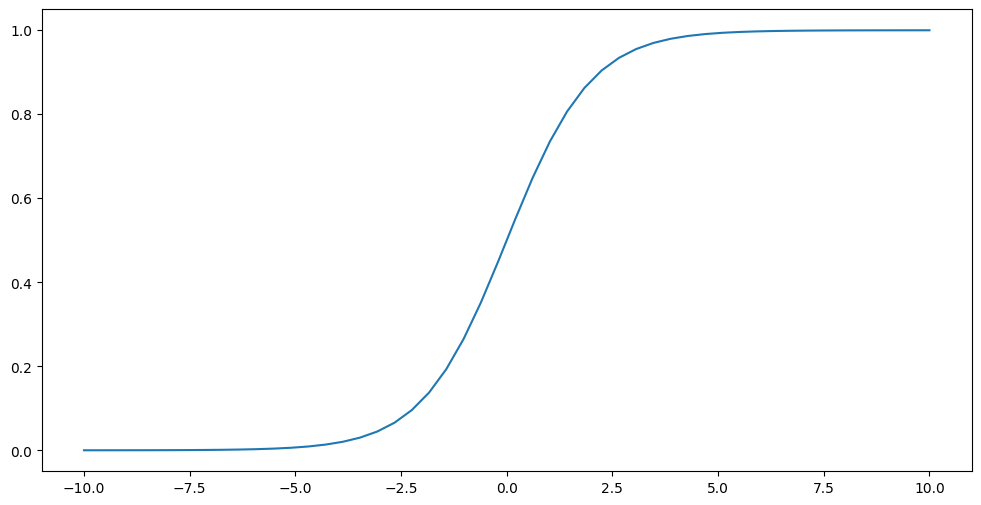

In [17]:
xs = np.linspace(-10,10,50)
ys = 1/(1+np.exp(-xs))
plt.figure(figsize=(12,6))
plt.plot(xs,ys)


Let us say that the probability of a point ${\mathbf x}$ being on the positive side of the hyper-plane ${\mathbf n}\cdot {\mathbf x}+b=0$ is 

$$\frac{1}{1+e^{-{\mathbf n}\cdot {\mathbf x} - b}}$$

Using this we can write a probability function $p({\mathbf x},y)$ that a point ${\mathbf x}$ having $y$ as the response as follows:

$$p({\mathbf x},y) = \left(\frac{1}{1+e^{-{\mathbf n}\cdot {\mathbf x} - b}}\right)^y \left(\frac{1}{1+e^{{\mathbf n}\cdot {\mathbf x} + b}}\right)^{1-y} $$
which measures the probability of ${\mathbf x}$ being on the right side where $y$ takes values 0 or 1.  Then the probability that all of the points in our dataset being on the right side is 

$$ p(D) = \prod_{i=1}^n p(x_i,y_i) $$ 

and therefore we would like to maximize $p(D)$ depending on the unknown parameters ${\mathbf n}\in\mathbb{R}^n$ and $b$. Instead one can minimize the following function 

$$ LE({\mathbf n},b) = -\frac{1}{n}\sum_{i=1}^n y_i\log(1+e^{-{\mathbf n}\cdot x_i - b}) + (1-y_i)\log(1+e^{{\mathbf n}\cdot x_i + b}) $$ 

which is just the natural logarithm of $p(D)$. Then the best-fitting ${\mathbf n}$ and $b$ is given by 

$$ \text{argmin}_{{\mathbf n,b}} LE({\mathbf n},b) $$



In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,yy[:,0],test_size=0.15)

model = logreg(max_iter=1000)
model.fit(X_train, y_train)
model.score(X_test, y_test)

/home/kaygun/.local/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8913043478260869

In [19]:
N = 10
scores = []

for i in range(N):
    X_train, X_test, y_train, y_test = train_test_split(X,yy[:,0],test_size=.25)

    model = logreg(max_iter=3000)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    scores.append(accuracy_score(y_predict, y_test))

mean = np.mean(scores)
interval = st.t.interval(0.05, df=splits-1, loc=mean, scale=st.sem(scores))

print(f"Average accuracy scpre:{mean}")
print(f"Testing accuracy:{interval}")

Average accuracy scpre:0.8065789473684211
Testing accuracy:(np.float64(0.8058040655160699), np.float64(0.8073538292207723))


In [20]:
X.corr()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
age,1.000000,-0.097542,0.104139,0.284946,0.208950,0.118530,0.148868,-0.393806,0.091661,0.203805,0.161770,0.365323,0.128340
sex,-0.097542,1.000000,0.010084,-0.064456,-0.199915,0.047862,0.021647,-0.048663,0.146201,0.102173,0.037533,0.086048,0.378155
cp,0.104139,0.010084,1.000000,-0.036077,0.072319,-0.039975,0.067505,-0.334422,0.384060,0.202277,0.152050,0.233117,0.254161
trestbps,0.284946,-0.064456,-0.036077,1.000000,0.130120,0.175340,0.146560,-0.045351,0.064762,0.189171,0.117382,0.097528,0.134311
chol,0.208950,-0.199915,0.072319,0.130120,1.000000,0.009841,0.171043,-0.003432,0.061310,0.046564,-0.004062,0.123726,0.025190
fbs,0.118530,0.047862,-0.039975,0.175340,0.009841,1.000000,0.069564,-0.007854,0.025665,0.005747,0.059894,0.140764,0.053608
restecg,0.148868,0.021647,0.067505,0.146560,0.171043,0.069564,1.000000,-0.083389,0.084867,0.114133,0.133946,0.131749,0.023822
thalach,-0.393806,-0.048663,-0.334422,-0.045351,-0.003432,-0.007854,-0.083389,1.000000,-0.378103,-0.343085,-0.385601,-0.265699,-0.263384
exang,0.091661,0.146201,0.384060,0.064762,0.061310,0.025665,0.084867,-0.378103,1.000000,0.288223,0.257748,0.145788,0.316134
oldpeak,0.203805,0.102173,0.202277,0.189171,0.046564,0.005747,0.114133,-0.343085,0.288223,1.000000,0.577537,0.301067,0.341416


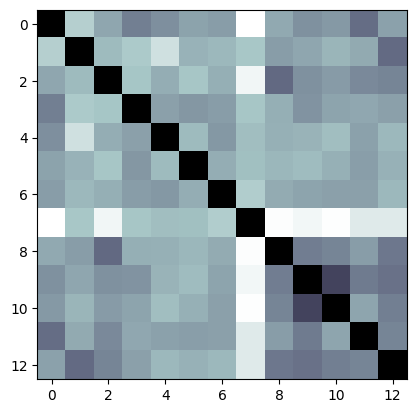

In [21]:
plt.imshow(X.corr(),cmap='bone_r')